In [668]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# print(tf.__version__)
import pandas as pd
import glob
import datetime
import os
import matplotlib.pyplot as plt
import itertools
import numpy as np
# import seaborn as sns
import joblib
from tensorflow.keras.layers import LSTM,Dense,Dropout
from keras.layers.advanced_activations import ReLU, LeakyReLU, PReLU
from tensorflow.keras.models import Model
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow import keras
from keras.utils import plot_model #, multi_gpu_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [669]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
 
sess0 = tf.compat.v1.InteractiveSession(config = config)

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


#### import data

In [ ]:
with open('./XsmoteTrain.xlsx','rb') as t:
    x_train = pd.read_excel(t)
    x_columns = x_train.columns
with open('./YsmoteTrain.xlsx','rb') as t:
    y_train = pd.read_excel(t,squeeze=True)
with open('./XsmoteTest.xlsx', 'rb') as f:
    x_test = pd.read_excel(f)
with open('./YsmoteTest.xlsx', 'rb') as f:
    y_test = pd.read_excel(f,squeeze=True)
with open('./Xvalid.xlsx', 'rb') as f:
    x_valid = pd.read_excel(f)
with open('./Yvalid.xlsx', 'rb') as f:
    y_valid = pd.read_excel(f,squeeze=True)

In [670]:
##tensorboard 
# tf.summary.histogram('x_test_histogram', x_test)
# tf.summary.histogram('x_train_histogram', x_train)

##undersampling
# from imblearn.under_sampling import RandomUnderSampler 
# rus = RandomUnderSampler(random_state=42)
# x_train, y_train = rus.fit_resample(x_train, y_train)
# x_valid, y_valid = rus.fit_resample(x_test, y_test)

##transform to float
# x_train = K.cast_to_floatx(x_train)
# y_train = K.cast_to_floatx(y_train)
# x_test = K.cast_to_floatx(x_test)
# y_test = K.cast_to_floatx(y_test)
# x_valid = K.cast_to_floatx(x_valid)
# y_valid = K.cast_to_floatx(y_valid)

In [671]:
##check shape
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2464, 16) (2464,) (275, 16) (275,)


#### Model setting

In [684]:
K.clear_session()
tf.reset_default_graph() 
from tensorflow.keras.activations import relu
input_layer = tf.keras.Input(shape=(16,))
ly = BatchNormalization()(ly)
ly = Dense(16, activation='relu')(input_layer)
# ly = relu(ly, alpha=0.2)
# ly = BatchNormalization()(ly)
# ly = Dense(18, activation='relu')(ly)
# ly = relu(ly, alpha=0.2)
# ly = BatchNormalization()(ly)
# ly = Dense(16, activation='relu')(ly)
# ly = relu(ly, alpha=0.2)
# ly = BatchNormalization()(ly)
# ly = Dense(16, activation='relu')(ly)
# ly = relu(ly, alpha=0.2)
ly = BatchNormalization()(ly)
ly = Dense(16, activation='relu')(ly)
ly = BatchNormalization()(ly)
ly = Dense(16, activation='relu')(ly)
ly = BatchNormalization()(ly)
output_layer = Dense(1, activation='sigmoid')(ly)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64    

#### Adaptive learning rate

In [685]:
def scheduler(epoch):
    lr = K.get_value(model.optimizer.lr)
    if epoch % 60 == 0 and epoch != 0:
        lr *= 0.1
    print('Learning rate: ', lr)
    return lr

#### Train model

In [686]:
AUC = tf.keras.metrics.AUC()
prec = tf.keras.metrics.Precision()
sens = tf.keras.metrics.Recall()
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.7, beta_2=0.8, epsilon=None, decay=0.0, amsgrad=False)
validation_data = (x_test,y_test)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
class_weight = {0: 10.,
                1: 50.}
my_lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300)

# parallel_model = multi_gpu_model(model, gpus=8)
model.compile(loss= loss,
              optimizer=opt,metrics=['accuracy',AUC,prec,sens]) 

checkpointer = ModelCheckpoint(filepath='/tmp/param.hdf5', verbose=1, save_best_only=True)
dnnmodel = model.fit(x_train, y_train, validation_data=validation_data, batch_size=30, epochs = 1000, callbacks=[checkpointer,early_stopping, my_lr_scheduler], class_weight=class_weight)
evalu = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)


Epoch 1/1000
Learning rate:  0.001
83/83 [==============================] - 5s 46ms/step - loss: 17.8057 - accuracy: 0.4894 - auc: 0.5135 - precision: 0.3865 - recall: 0.6565 - val_loss: 0.7854 - val_accuracy: 0.3709 - val_auc: 0.5323 - val_precision: 0.3633 - val_recall: 0.9029

Epoch 00001: val_loss improved from inf to 0.78538, saving model to /tmp/param.hdf5
Epoch 2/1000
Learning rate:  0.001
83/83 [==============================] - 0s 4ms/step - loss: 15.2443 - accuracy: 0.4590 - auc: 0.5905 - precision: 0.4022 - recall: 0.8487 - val_loss: 0.8774 - val_accuracy: 0.3636 - val_auc: 0.5586 - val_precision: 0.3636 - val_recall: 0.9320

Epoch 00002: val_loss did not improve from 0.78538
Epoch 3/1000
Learning rate:  0.001
83/83 [==============================] - 1s 17ms/step - loss: 14.0181 - accuracy: 0.4488 - auc: 0.6154 - precision: 0.4035 - recall: 0.9591 - val_loss: 0.9361 - val_accuracy: 0.3673 - val_auc: 0.5851 - val_precision: 0.3650 - val_recall: 0.9320

Epoch 00003: val_loss d


Epoch 00025: val_loss did not improve from 0.78538
Epoch 26/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.6343 - accuracy: 0.4808 - auc: 0.7115 - precision: 0.4159 - recall: 0.9494 - val_loss: 0.8573 - val_accuracy: 0.4691 - val_auc: 0.7029 - val_precision: 0.4093 - val_recall: 0.9417

Epoch 00026: val_loss did not improve from 0.78538
Epoch 27/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.8111 - accuracy: 0.4859 - auc: 0.6878 - precision: 0.4257 - recall: 0.9652 - val_loss: 0.8975 - val_accuracy: 0.4800 - val_auc: 0.6953 - val_precision: 0.4153 - val_recall: 0.9515

Epoch 00027: val_loss did not improve from 0.78538
Epoch 28/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.9808 - accuracy: 0.4861 - auc: 0.6928 - precision: 0.4289 - recall: 0.9510 - val_loss: 0.8301 - val_accuracy: 0.4945 - val_auc: 0.7137 - val_precision: 0.4224 - val_recall: 0.9515

Epo


Epoch 00050: val_loss did not improve from 0.78538
Epoch 51/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.7055 - accuracy: 0.4895 - auc: 0.6994 - precision: 0.4205 - recall: 0.9742 - val_loss: 0.8624 - val_accuracy: 0.5018 - val_auc: 0.7205 - val_precision: 0.4286 - val_recall: 0.9903

Epoch 00051: val_loss did not improve from 0.78538
Epoch 52/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.8408 - accuracy: 0.4705 - auc: 0.6956 - precision: 0.4099 - recall: 0.9463 - val_loss: 0.8609 - val_accuracy: 0.4873 - val_auc: 0.7000 - val_precision: 0.4202 - val_recall: 0.9709

Epoch 00052: val_loss did not improve from 0.78538
Epoch 53/1000
Learning rate:  0.001
83/83 [==============================] - 0s 3ms/step - loss: 12.6422 - accuracy: 0.4709 - auc: 0.7062 - precision: 0.4069 - recall: 0.9705 - val_loss: 0.8475 - val_accuracy: 0.5091 - val_auc: 0.7114 - val_precision: 0.4316 - val_recall: 0.9806

Epo

83/83 [==============================] - 0s 3ms/step - loss: 12.2838 - accuracy: 0.5015 - auc: 0.7275 - precision: 0.4282 - recall: 0.9564 - val_loss: 0.8407 - val_accuracy: 0.4873 - val_auc: 0.6996 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00075: val_loss did not improve from 0.78538
Epoch 76/1000
Learning rate:  0.000100000005
83/83 [==============================] - 0s 3ms/step - loss: 11.9923 - accuracy: 0.5126 - auc: 0.7488 - precision: 0.4371 - recall: 0.9673 - val_loss: 0.8434 - val_accuracy: 0.4873 - val_auc: 0.7017 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00076: val_loss did not improve from 0.78538
Epoch 77/1000
Learning rate:  0.000100000005
83/83 [==============================] - 0s 3ms/step - loss: 12.2294 - accuracy: 0.5170 - auc: 0.7415 - precision: 0.4467 - recall: 0.9527 - val_loss: 0.8456 - val_accuracy: 0.4909 - val_auc: 0.7011 - val_precision: 0.4213 - val_recall: 0.9612

Epoch 00077: val_loss did not improve from 0.78538
Epoch 78/1000
Learning

83/83 [==============================] - 0s 3ms/step - loss: 12.2469 - accuracy: 0.5057 - auc: 0.7314 - precision: 0.4259 - recall: 0.9621 - val_loss: 0.8483 - val_accuracy: 0.4873 - val_auc: 0.7092 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00099: val_loss did not improve from 0.78538
Epoch 100/1000
Learning rate:  0.000100000005
83/83 [==============================] - 0s 3ms/step - loss: 12.0040 - accuracy: 0.5055 - auc: 0.7489 - precision: 0.4177 - recall: 0.9692 - val_loss: 0.8439 - val_accuracy: 0.4873 - val_auc: 0.7137 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00100: val_loss did not improve from 0.78538
Epoch 101/1000
Learning rate:  0.000100000005
83/83 [==============================] - 0s 3ms/step - loss: 12.2845 - accuracy: 0.5072 - auc: 0.7335 - precision: 0.4356 - recall: 0.9576 - val_loss: 0.8418 - val_accuracy: 0.4873 - val_auc: 0.7125 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00101: val_loss did not improve from 0.78538
Epoch 102/1000
Learn

83/83 [==============================] - 0s 3ms/step - loss: 12.3050 - accuracy: 0.5020 - auc: 0.7303 - precision: 0.4280 - recall: 0.9535 - val_loss: 0.8519 - val_accuracy: 0.4873 - val_auc: 0.7044 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00123: val_loss did not improve from 0.78538
Epoch 124/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.2420 - accuracy: 0.4998 - auc: 0.7355 - precision: 0.4260 - recall: 0.9665 - val_loss: 0.8559 - val_accuracy: 0.4873 - val_auc: 0.7051 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00124: val_loss did not improve from 0.78538
Epoch 125/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.0091 - accuracy: 0.5116 - auc: 0.7463 - precision: 0.4236 - recall: 0.9657 - val_loss: 0.8545 - val_accuracy: 0.4873 - val_auc: 0.7043 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00125: val_loss did not improve from 0.78538
Epoch 126/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.0623 - accuracy: 0.5167 - auc: 0.7489 - precision: 0.4361 - recall: 0.9637 - val_loss: 0.8501 - val_accuracy: 0.4873 - val_auc: 0.7057 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00147: val_loss did not improve from 0.78538
Epoch 148/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.4170 - accuracy: 0.5044 - auc: 0.7258 - precision: 0.4265 - recall: 0.9669 - val_loss: 0.8486 - val_accuracy: 0.4873 - val_auc: 0.7030 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00148: val_loss did not improve from 0.78538
Epoch 149/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.0567 - accuracy: 0.5260 - auc: 0.7468 - precision: 0.4492 - recall: 0.9675 - val_loss: 0.8500 - val_accuracy: 0.4873 - val_auc: 0.7044 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00149: val_loss did not improve from 0.78538
Epoch 150/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.3528 - accuracy: 0.4921 - auc: 0.7333 - precision: 0.4111 - recall: 0.9544 - val_loss: 0.8461 - val_accuracy: 0.4836 - val_auc: 0.7047 - val_precision: 0.4163 - val_recall: 0.9417

Epoch 00171: val_loss did not improve from 0.78538
Epoch 172/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.0180 - accuracy: 0.5275 - auc: 0.7403 - precision: 0.4491 - recall: 0.9700 - val_loss: 0.8436 - val_accuracy: 0.4873 - val_auc: 0.7060 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00172: val_loss did not improve from 0.78538
Epoch 173/1000
Learning rate:  1.0000001e-05
83/83 [==============================] - 0s 3ms/step - loss: 12.2958 - accuracy: 0.5112 - auc: 0.7262 - precision: 0.4274 - recall: 0.9541 - val_loss: 0.8458 - val_accuracy: 0.4873 - val_auc: 0.7050 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00173: val_loss did not improve from 0.78538
Epoch 174/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.2016 - accuracy: 0.5211 - auc: 0.7356 - precision: 0.4471 - recall: 0.9665 - val_loss: 0.8449 - val_accuracy: 0.4873 - val_auc: 0.7047 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00195: val_loss did not improve from 0.78538
Epoch 196/1000
Learning rate:  1.0000001e-06
83/83 [==============================] - 0s 3ms/step - loss: 12.0728 - accuracy: 0.5085 - auc: 0.7591 - precision: 0.4316 - recall: 0.9527 - val_loss: 0.8490 - val_accuracy: 0.4873 - val_auc: 0.7028 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00196: val_loss did not improve from 0.78538
Epoch 197/1000
Learning rate:  1.0000001e-06
83/83 [==============================] - 0s 3ms/step - loss: 12.2022 - accuracy: 0.5072 - auc: 0.7399 - precision: 0.4331 - recall: 0.9605 - val_loss: 0.8526 - val_accuracy: 0.4873 - val_auc: 0.7006 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00197: val_loss did not improve from 0.78538
Epoch 198/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.5432 - accuracy: 0.5099 - auc: 0.7013 - precision: 0.4341 - recall: 0.9713 - val_loss: 0.8509 - val_accuracy: 0.4873 - val_auc: 0.7027 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00219: val_loss did not improve from 0.78538
Epoch 220/1000
Learning rate:  1.0000001e-06
83/83 [==============================] - 0s 3ms/step - loss: 11.8356 - accuracy: 0.5003 - auc: 0.7595 - precision: 0.4222 - recall: 0.9677 - val_loss: 0.8521 - val_accuracy: 0.4873 - val_auc: 0.7048 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00220: val_loss did not improve from 0.78538
Epoch 221/1000
Learning rate:  1.0000001e-06
83/83 [==============================] - 0s 3ms/step - loss: 12.4674 - accuracy: 0.5241 - auc: 0.7319 - precision: 0.4484 - recall: 0.9450 - val_loss: 0.8559 - val_accuracy: 0.4873 - val_auc: 0.7016 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00221: val_loss did not improve from 0.78538
Epoch 222/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.0948 - accuracy: 0.5127 - auc: 0.7328 - precision: 0.4314 - recall: 0.9650 - val_loss: 0.8516 - val_accuracy: 0.4873 - val_auc: 0.7015 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00243: val_loss did not improve from 0.78538
Epoch 244/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 12.4498 - accuracy: 0.5112 - auc: 0.7266 - precision: 0.4345 - recall: 0.9442 - val_loss: 0.8497 - val_accuracy: 0.4836 - val_auc: 0.7030 - val_precision: 0.4163 - val_recall: 0.9417

Epoch 00244: val_loss did not improve from 0.78538
Epoch 245/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 12.2262 - accuracy: 0.5141 - auc: 0.7404 - precision: 0.4396 - recall: 0.9606 - val_loss: 0.8487 - val_accuracy: 0.4873 - val_auc: 0.7047 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00245: val_loss did not improve from 0.78538
Epoch 246/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.3183 - accuracy: 0.5052 - auc: 0.7287 - precision: 0.4258 - recall: 0.9464 - val_loss: 0.8484 - val_accuracy: 0.4873 - val_auc: 0.7007 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00267: val_loss did not improve from 0.78538
Epoch 268/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 12.1861 - accuracy: 0.5156 - auc: 0.7402 - precision: 0.4362 - recall: 0.9607 - val_loss: 0.8467 - val_accuracy: 0.4873 - val_auc: 0.7011 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00268: val_loss did not improve from 0.78538
Epoch 269/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 11.9408 - accuracy: 0.4982 - auc: 0.7534 - precision: 0.4133 - recall: 0.9556 - val_loss: 0.8519 - val_accuracy: 0.4873 - val_auc: 0.7026 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00269: val_loss did not improve from 0.78538
Epoch 270/1000
Learnin

83/83 [==============================] - 0s 3ms/step - loss: 12.3535 - accuracy: 0.5262 - auc: 0.7158 - precision: 0.4514 - recall: 0.9646 - val_loss: 0.8502 - val_accuracy: 0.4873 - val_auc: 0.7031 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00291: val_loss did not improve from 0.78538
Epoch 292/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 12.3177 - accuracy: 0.5072 - auc: 0.7290 - precision: 0.4251 - recall: 0.9555 - val_loss: 0.8470 - val_accuracy: 0.4873 - val_auc: 0.7022 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00292: val_loss did not improve from 0.78538
Epoch 293/1000
Learning rate:  1.0000001e-07
83/83 [==============================] - 0s 3ms/step - loss: 12.0383 - accuracy: 0.4996 - auc: 0.7451 - precision: 0.4252 - recall: 0.9616 - val_loss: 0.8466 - val_accuracy: 0.4873 - val_auc: 0.7039 - val_precision: 0.4188 - val_recall: 0.9515

Epoch 00293: val_loss did not improve from 0.78538
Epoch 294/1000
Learnin

#### Result

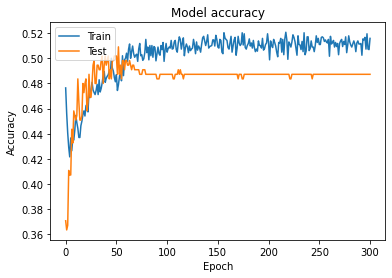

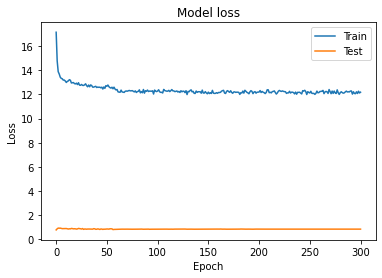

In [687]:
# plot accuracy of training and validating 
plt.plot(dnnmodel.history['accuracy'])
plt.plot(dnnmodel.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot loss of training and validating 
plt.plot(dnnmodel.history['loss'])
plt.plot(dnnmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [688]:
result = {"Loss":evalu[0],
          "Accuracy":evalu[1],
          "AUC":evalu[2],
          "Precision":evalu[3],
          "Recall":evalu[4]}

In [703]:
print(result)

                    0
precision    0.426667
sensitivity  0.516129
accuracy     0.717054
F1           0.467153
specificity  0.780612


[[119  53]
 [ 46  57]]


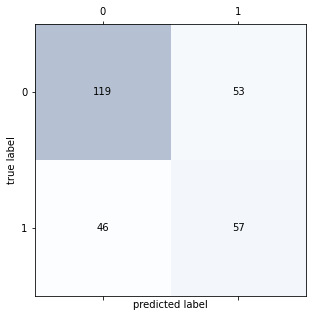

                    0
precision    0.518182
sensitivity  0.553398
accuracy     0.640000
F1           0.535211
specificity  0.691860
[[119  53]
 [ 46  57]]


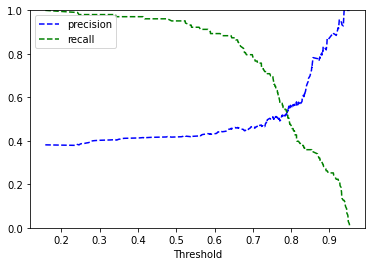

In [690]:
# result of testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(x_test)
thre = 0.78

y_class = []
for i in y_pred:
    if i[0] > thre:
        y_class.append(1)
    else:
        y_class.append(0)
    
CM = confusion_matrix(y_test,y_class)
print(CM)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(CM, cmap=plt.cm.Blues, alpha=0.3)
for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
        ax.text(x=j, y=i, s=CM[i,j], va='center', ha='center')

TP = CM[1][1]
FP = CM[0][1]
TN = CM[0][0]
FN = CM[1][0]
precision = TP/(TP+FP)
sensitivity = TP/(TP+FN)
accuracy = (TN+TP)/(TN+TP+FN+FP)
specificity = TN/(TN+FP)
F1 = 2*precision*sensitivity / (precision+sensitivity)

result = pd.DataFrame([precision, sensitivity, accuracy, F1, specificity], index = ['precision', 'sensitivity', 'accuracy', 'F1', 'specificity'])


plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
print(result)
print(CM)


from sklearn.metrics import precision_recall_curve
prec, rec, tre = precision_recall_curve(y_test, y_pred)
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.savefig('PR_threshold_0420.png')


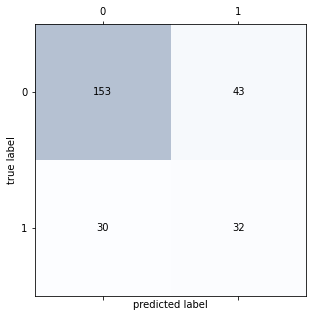

                    0
precision    0.426667
sensitivity  0.516129
accuracy     0.717054
F1           0.467153
specificity  0.780612
[[153  43]
 [ 30  32]]


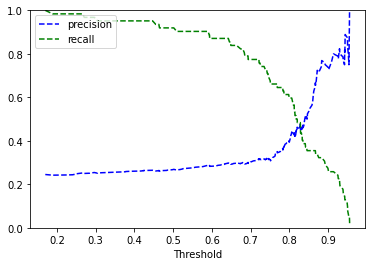

In [702]:
# result of validating
y_pred = model.predict(x_valid)

y_class = []
for i in y_pred:
    if i[0] > 0.815:
        y_class.append(1)
    else:
        y_class.append(0)
    
CM = confusion_matrix(y_valid,y_class)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(CM, cmap=plt.cm.Blues, alpha=0.3)
for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
        ax.text(x=j, y=i, s=CM[i,j], va='center', ha='center')

TP = CM[1][1]
FP = CM[0][1]
TN = CM[0][0]
FN = CM[1][0]
precision = TP/(TP+FP)
sensitivity = TP/(TP+FN)
accuracy = (TN+TP)/(TN+TP+FN+FP)
specificity = TN/(TN+FP)
F1 = 2*precision*sensitivity / (precision+sensitivity)

result = pd.DataFrame([precision, sensitivity, accuracy, F1, specificity], index = ['precision', 'sensitivity', 'accuracy', 'F1', 'specificity'])


plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()
print(result)
print(CM)


from sklearn.metrics import precision_recall_curve
prec, rec, tre = precision_recall_curve(y_valid, y_pred)
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.savefig('PR_threshold_0420.png')

In [700]:
print(len(y_train[y_train==True]))
print(len(y_train[y_train==False]))
print(len(y_test[y_test==True]))
print(len(y_test[y_test==False]))
print(len(y_valid[y_valid==True]))
print(len(y_valid[y_valid==False]))

924
1540
103
172
62
196


In [693]:
print(len(y_train[y_train==True])/len(y_train[y_train==False]))
print(len(y_test[y_test==True])/len(y_test[y_test==False]))
print(len(y_valid[y_valid==True])/len(y_valid[y_valid==False]))

0.6
0.5988372093023255
0.3163265306122449


In [694]:
#describing values of classfication 
true_thre = []
false_thre = []
for i in range(0, len(y_pred)-1):
    if y_valid[i] == True:
        true_thre.append(y_pred[i][0])
    else:
        false_thre.append(y_pred[i][0])
        
true = pd.DataFrame(true_thre)
false = pd.DataFrame(false_thre)
print(true.describe())
print(false.describe())

               0
count  62.000000
mean    0.780156
std     0.173403
min     0.170243
25%     0.726681
50%     0.818724
75%     0.910278
max     0.955635
                0
count  195.000000
mean     0.656346
std      0.204762
min      0.033659
25%      0.545332
50%      0.738370
75%      0.803800
max      0.953779


In [695]:
#save model
model.save('dnn.h5') 

In [ ]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=1)
from statsmodels.graphics.api import abline_plot
ax.scatter(y_pred, y_valid, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
# ax[0].vlines(x=y_pred.max(), ymin=y_valid.max(), ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax.grid(True)
ax.set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax.legend()

In [ ]:
##plot lime
import lime
import lime.lime_tabular
x_ary = x_train.to_numpy()
val_ary = x_valid.to_numpy()

explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                                   feature_names=x_columns, 
                                                   class_names=['values'], 
                                                   verbose=True,  discretize_continuous=True)

for i in range(0, len(val_ary)-1):
    exp = explainer.explain_instance(val_ary[i], 
                                     model.predict, 
                                     num_features=10,
                                     top_labels=10)
#     exp.show_in_notebook(show_table=True)
print(y_pred[i], y_test.values[i])

In [ ]:
##plot shap
import shap
import ipywidgets as widgets

idx = 100

explainer = shap.KernelExplainer(model = model.predict, data = x_train, link = "identity")

shap_values = explainer.shap_values(x_train)
# list_of_labels = y_valid.to_list()
# tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))
# current_label = widgets.Dropdown(options=tuple_of_labels,
#                               value=0,
#                               description='Select Label:')
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, x_train)
# shap.plots.waterfall(shap_values[0])